<a href="https://colab.research.google.com/github/ImaginationX4/Path_to_MARL/blob/master/Router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Env setting

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
#x:start_node y:end_node neighbr means neighbot node, edge is connection between nodes
class Router(object):
	def __init__(self, x, y):
		self.x = x
		self.y = y
		self.neighbor = []
		self.edge=[]#which edege am i(Nr.1/2/3)
	def __str__(self):
		return f'neighbor:{self.neighbor},edge:{self.edge}'


#start_x ---> end_y l:distance
class Edge(object):
	def __init__(self, x, y, l):
		self.start = x
		self.end = y
		self.len = int(int(l*10)/2+1)
		self.load = 0
	def __str__(self):
		return f'start:{self.start},end:{self.end}'
#xize? priotity?
class Data(object):
	def __init__(self, x, y, size, priority):
		self.now = x
		self.target = y
		self.size = size
		self.priority = priority
		self.time = 0
		self.edge = -1
		self.neigh = [priority,-1,-1,-1]
	def __str__(self):
		return f'now:{self.now},target:{self.target}'


###build the graph

In [2]:
#man it is so random,wwhat is it?????
router = [] #collection of router
edge_index=[]
edges = [] #edges with direction and distance
t_edge = 0
n_router = 20#number of router
for i in range(n_router):
	router.append(Router(np.random.random(),np.random.random()))


####build router

In [3]:
for i in range(n_router):

	dis = []#distannce from every other nodes to node i
	for j in range(n_router):
		dis.append([(router[j].x - router[i].x)**2 + (router[j].y - router[i].y)**2, j])
	dis.sort(key = lambda x: x[0],reverse = False)

	for j in range(n_router):
    #check number of neighbors
		if len(router[i].neighbor) == 3:
			break
		if j == 0 :
			continue

		if len(router[dis[j][1]].neighbor) < 3:
      #give router a neighbor
			router[i].neighbor.append(dis[j][1])
			router[dis[j][1]].neighbor.append(i)

			if i<dis[j][1]:
        #adding edges with direction and distance
				edges.append(Edge(i,dis[j][1],np.sqrt(dis[j][0])))
				router[i].edge.append(t_edge)
				router[dis[j][1]].edge.append(t_edge)
				t_edge += 1
			else:
				edges.append(Edge(dis[j][1],i,np.sqrt(dis[j][0])))
				router[dis[j][1]].edge.append(t_edge)
				router[i].edge.append(t_edge)
				t_edge += 1


In [4]:
i=0
edge1= np.array(edges)
for x in router:
  print('router: '+f'{i}')
  print(x)
  b=np.array(x.edge)
  print('edge:')
  for s in edge1[b]:
    print(s)

  i+=1
  if i>2:
    break

router: 0
neighbor:[12, 16, 3],edge:[0, 1, 2]
edge:
start:0,end:12
start:0,end:16
start:0,end:3
router: 1
neighbor:[19, 4, 17],edge:[3, 4, 5]
edge:
start:1,end:19
start:1,end:4
start:1,end:17
router: 2
neighbor:[7, 18, 11],edge:[6, 7, 8]
edge:
start:2,end:7
start:2,end:18
start:2,end:11


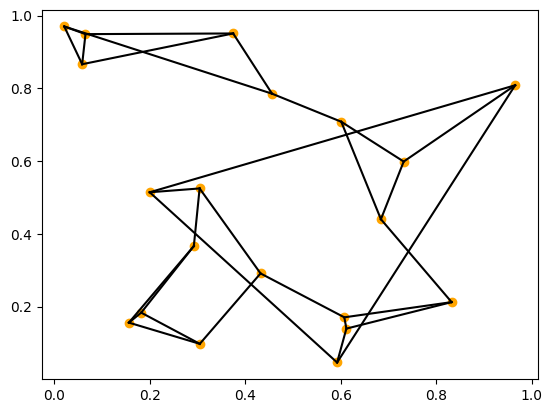

In [5]:
for i in range(n_router):
	plt.scatter(router[i].x, router[i].y, color = 'orange')
for e in edges:
	plt.plot([router[e.start].x,router[e.end].x],[router[e.start].y,router[e.end].y],color='black')

#### observation function

In [6]:
data = []
n_data = 20
#data(nr.router, nr.router, size(random_numbe), priority(Nr))
for i in range(n_data):
	data.append(Data(np.random.randint(n_router),np.random.randint(n_router),np.random.random(),i))
#router(postions), edges(edges), data(??), number of data, t_edge(number of data)
def observation(router, edges, data, n_router, n_data):
	obs = []
	for i in range(n_data):
		ob=[]

		####meta information of i_data####
		ob.append(data[i].now)
		ob.append(data[i].target)
		ob.append(data[i].edge)
		ob.append(data[i].size)
		ob.append(data[i].priority)

		####edge information of i_now_node####
		for j in router[data[i].now].edge:
			ob.append(j)
			ob.append(edges[j].start)
			ob.append(edges[j].end)
			ob.append(edges[j].len)
			ob.append(edges[j].load)


		obs.append(np.array(ob))

	return obs


In [7]:
test_obs=np.array(observation(router, edges, data, n_router, n_data))


####action funtcion

In [8]:
def set_action(act,edges, data, n_data, t_edge):

	reward = [0]*n_data
	done = [False]*n_data

  #data.time = 0 data.edge = -1 data.size=size  edge.load = 0
	for i in range(n_data):
		if data[i].edge != -1:
			data[i].time -= 1
			if data[i].time == 0:
				edges[data[i].edge].load -= data[i].size
				data[i].edge = -1

		elif act[i]==0:
			continue

		else:
			#print(act[i])
			#print(router[data[i].now].edge)

			t = router[data[i].now].edge[act[i]]#-1
			t1 = router[data[i].now].edge[act[i-1]]
			now = data[i].now
			#print(edges[t])

			if edges[t].load + data[i].size >1:
				#print("wrong way")
				reward[i] = -0.2
			else:
				data[i].edge = t
				data[i].time = edges[t].len
				edges[t].load += data[i].size

				if edges[t].start == data[i].now:
					#print("next 1")
					data[i].now = edges[t].end
				elif data[i].now == router[data[i].now].neighbor[act[i]]:
					#print("stay there")
					data[i].now = data[i].now
				else:
					#print("next2")
					data[i].now = edges[t].start
			#print(f'next_router is {data[i].now}, now_router is {now} {router[data[i].now]}')
		if data[i].now == data[i].target:
			reward[i] = 10
			done[i] = True


	return data, edges, reward, done

In [9]:
act=[1]*20
b=set_action(act,edges, data, n_data, t_edge)

###Model

In [10]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.3.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [11]:
import torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = torch_geometric.nn.GCNConv(input_dim, hidden_dim, aggr='add')
        self.conv2 = torch_geometric.nn.GCNConv(hidden_dim, output_dim, aggr='add')
        self.soft = nn.Softmax(dim=0)

    def forward(self, x, edge_index):
        #print(x.shape)
        #print(edge_index.shape)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        #x = self.soft(x)
        return x

In [14]:
test_model = GCN(20,40,2)
a=[test_obs,test_obs]
a=torch.tensor(a, dtype=torch.float).detach()
#test_obs=test_obs.view(1,-1).squeeze(0)
edge_index=torch.tensor(edge_index, dtype=torch.int).detach()
#result_gnn=test_model(a,edge_index)



<ipython-input-14-44cd313528fe>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edge_index, dtype=torch.int).detach()


In [15]:
class Actor_net(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.layer_int = nn.Linear(state_size, 64)
        self.layer_out = nn.Linear(64, action_size)
    def forward(self, inputs):
        q_values = self.layer_int(inputs)
        q_values = self.layer_out(q_values)
        #action = torch.argmax(q_values).item()
        return q_values#.detach().numpy()

In [ ]:
test_actor = Actor_net(20,20)
#test_actor(result_gnn)

###Replay Buffer

In [16]:
import numpy as np
import random

class ReplayBuffer:
  def __init__(self,batch_size,max_size):
    self.num_data = 0
    self.max_size= max_size
    self.batch_size=batch_size
    self.count=0
    self.router_size= 20
    self.state_size =20
    self.obs = np.zeros((max_size,self.router_size,self.state_size))
    self.obs_ = np.zeros((max_size,self.router_size,self.state_size))
    self.actions = np.zeros((max_size,self.router_size))
    self.rewards = np.zeros((max_size,self.router_size))
    self.dones = np.zeros((max_size,self.router_size), dtype=bool)

  def add(self,ob,action,reward,ob_, done):

    self.obs[self.count]=ob
    self.obs_[self.count]=ob_
    self.actions[self.count]=action
    self.rewards[self.count]=reward
    self.dones[self.count]=done

    self.count=(self.count+1) % self.max_size
    self.num_data+=1

  def simple(self,size):

    max = min(self.max_size, self.num_data)
    index = np.random.choice(max,size)
    return self.obs[index],self.actions[index],self.rewards[index],self.obs_[index],self.dones[index]

  def ready(self):
    return self.num_data >= self.batch_size


In [17]:
a=ReplayBuffer(100,1000)
ob = test_obs
ob_ = test_obs
action = np.zeros((1,20))
reward = np.zeros((1,20))
done = np.zeros((1,20),dtype=np.bool_)
a.add(ob,action,reward,ob_, done)

###setting up for training

In [18]:
class Agent:
  def __init__(self):
    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.actor = Actor_net(20,3).to(device)
    self.target_actor = Actor_net(20,3).to(device)

  def choose_action(self, observation):
    action = self.actor(observation)
    return action
  def update(self):
    tau = 0.001
    for p1_,p1 in zip(self.target_actor.parameters(),self.actor.parameters()):
        new_val = tau*p1+(1-tau)*p1_
        p1_.copy_(new_val)
  def update_network_parameters(self, tau=None):
      if tau is None:
          tau = 0.001

      target_actor_params = self.target_actor.named_parameters()
      actor_params = self.actor.named_parameters()

      target_actor_state_dict = dict(target_actor_params)
      actor_state_dict = dict(actor_params)
      for name in actor_state_dict:
          actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                  (1-tau)*target_actor_state_dict[name].clone()

      self.target_actor.load_state_dict(actor_state_dict)



In [19]:
EOPCH =1000
device = "cuda" if torch.cuda.is_available() else "cpu"
memory=ReplayBuffer(20,1000)
gcn_model = GCN(20,40,20).to(device)
agents = []
optimizers= []
fn = nn.MSELoss()

for i in range(20):
  agents.append(Agent())
  optimizer = optim.Adam(agents[i].actor.parameters(), lr=0.0001)
  optimizers.append(optimizer)
for i in range(100):
  act =np.random.randint(0,3,size=(len(data),))
  ob=observation(router, edges, data, n_router, n_data)
  data, edges, reward, dones = set_action(act,edges, data, n_data, t_edge)
  ob_=observation(router, edges, data, n_router, n_data)
  memory.add(ob,act,reward,ob_, dones)

for i in range(EOPCH):
  if i%100==0:
    print(i)

  states, actions, rewards, states_, dones = memory.simple(100)



  edge_index=[]
  edge_i1=[]
  edge_i2=[]
  for edge in edges:
    edge_i1.append(edge.start)
    edge_i1.append(edge.end)
    edge_i2.append(edge.end)
    edge_i2.append(edge.start)
  edge_index.append(edge_i1)
  edge_index.append(edge_i2)

  states_t = torch.as_tensor(states,dtype=torch.float32).to(device)
  edge_index = torch.as_tensor(edge_index, dtype=torch.int64).to(device)
  gcn_output = gcn_model(states_t,edge_index)
  #print(gcn_output[:,:,1].size())

  for index in range(20):#number of routers
    h=gcn_output[:,index,:]
    dones_t = torch.tensor(dones[:,index],dtype=torch.float32).view(-1,1).to(device)
    rewards_t = torch.tensor(rewards[:,index],dtype=torch.float32).view(-1,1).to(device)
    action_t = torch.tensor(actions[:,index],dtype=torch.int64).view(-1,1).to(device)

    gamma=0.99
    max_q_action = agents[index].target_actor(h).max(dim=1,keepdim=True)[0]
    #print(gcn_model(states_t,edge_index).size())
    #print(rewards_t+max_q_action*(1-dones_t))
    target  = rewards_t+ gamma * max_q_action *(1-dones_t)
    q_values = agents[index].actor(h).gather(dim=-1,index=action_t)
    #print(actions)

    loss=fn(q_values,target)
    optimizers[index].zero_grad()
    loss.backward(retain_graph=True)
    optimizers[index].step()

    agents[index].update_network_parameters()
  with torch.no_grad():
    actions_test=[]
    ob_test=observation(router, edges, data, n_router, n_data)
    ob_test = torch.as_tensor(ob_test,dtype=torch.float32).to(device)
    gcn_output_test = gcn_model(ob_test,edge_index)
    #print(gcn_output_test.size())
    for index in range(20):
      h=gcn_output_test[index]
      a= torch.argmax(agents[index].target_actor(h)).item()
      #print("result")
      #print(agents[index].target_actor(h).size())
      actions_test.append(a)

    ob=observation(router, edges, data, n_router, n_data)

    data, edges, reward, dones = set_action(actions_test,edges, data, n_data, t_edge)
    ob_=observation(router, edges, data, n_router, n_data)
    memory.add(ob,actions_test,reward,ob_, dones)







0


###check the result

In [20]:
router = [] #collection of router
edges = [] #edges with direction and distance
t_edge = 0
n_router = 20#number of router
for i in range(n_router):
	router.append(Router(np.random.random(),np.random.random()))

for i in range(n_router):

	dis = []#distannce from every other nodes to node i
	for j in range(n_router):
		dis.append([(router[j].x - router[i].x)**2 + (router[j].y - router[i].y)**2, j])
	dis.sort(key = lambda x: x[0],reverse = False)

	for j in range(n_router):
    #check number of neighbors
		if len(router[i].neighbor) == 3:
			break
		if j == 0 :
			continue

		if len(router[dis[j][1]].neighbor) < 3:
      #give router a neighbor
			router[i].neighbor.append(dis[j][1])
			router[dis[j][1]].neighbor.append(i)

			if i<dis[j][1]:
        #adding edges with direction and distance
				edges.append(Edge(i,dis[j][1],np.sqrt(dis[j][0])))
				router[i].edge.append(t_edge)
				router[dis[j][1]].edge.append(t_edge)
				t_edge += 1
			else:
				edges.append(Edge(dis[j][1],i,np.sqrt(dis[j][0])))
				router[dis[j][1]].edge.append(t_edge)
				router[i].edge.append(t_edge)
				t_edge += 1
data = []
n_data = 20
#data(nr.router, nr.router, size(random_numbe), priority(Nr))
for i in range(n_data):
	data.append(Data(np.random.randint(n_router),np.random.randint(n_router),np.random.random(),i))

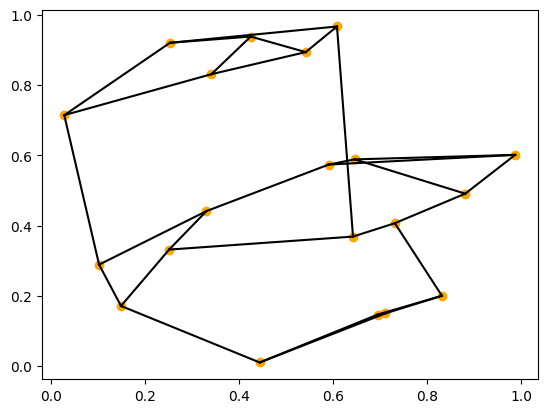

In [21]:
for i in range(n_router):
	plt.scatter(router[i].x, router[i].y, color = 'orange')
for e in edges:
	plt.plot([router[e.start].x,router[e.end].x],[router[e.start].y,router[e.end].y],color='black')

In [23]:
actions_test=[]
edge_index=[]
edge_i1=[]
edge_i2=[]
for edge in edges:
  edge_i1.append(edge.start)
  edge_i1.append(edge.end)
  edge_i2.append(edge.end)
  edge_i2.append(edge.start)
edge_index.append(edge_i1)
edge_index.append(edge_i2)
edge_index = torch.as_tensor(edge_index, dtype=torch.int64).to(device)

ob_test=observation(router, edges, data, n_router, n_data)
ob_test = torch.as_tensor(ob_test,dtype=torch.float32).to(device)
for i in range(20000):
  gcn_output_test = gcn_model(ob_test,edge_index)
  #print(gcn_output_test.size())
  for index in range(20):
    h=gcn_output_test[index,:]
    a= torch.argmax(agents[index].target_actor(h)).item()
    #print("result")
    #print(agents[index].target_actor(h).size())
    actions_test.append(a)


  data, edges, reward, dones = set_action(actions_test,edges, data, n_data, t_edge)
  print(reward)
  tem=observation(router, edges, data, n_router, n_data)
  ob_test = torch.as_tensor(tem,dtype=torch.float32).to(device)


流式输出内容被截断，只能显示最后 5000 行内容。
[0, 0, 0, 10, 0, -0.2, 0, 10, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 10, -0.2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 10, 0, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 10, 0, 0, 0, 10, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, -0.2, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, -0.2, 0, 10, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 0, 0, 0, 0]
[0, 0, 0, 10, 0, 0, 0, 0, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 0]
[0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 0, 0, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 10, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 10, -0.2, 0, 0]
[0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, -0.2, 0, 10, 0, 0, 0]
[0, 0, 0, 10, 0, -0.2, 0, 10, 0, 0, 0, -0.2, 0, 0, -0.2, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, -0.2, 0, 0, 0, 0, 0, -0.2, 0, 0, -0.2, 0